In [17]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# --- 文件路径设置 ---
sanheyi_file = '三合一.xlsx'
fujian1_file = '附件1.xlsx'
model_output_file = '单品销量预测模型.xgb'

# --- 加载数据 ---
try:
    df_sanheyi_raw = pd.read_excel(sanheyi_file)
    df_fujian1 = pd.read_excel(fujian1_file)
    print("数据加载成功！")
except FileNotFoundError as e:
    print(f"错误：确保所有文件存在于当前目录。缺失文件: {e.filename}")
    exit()

# --- 数据预处理和特征工程 ---
start_date = '2023-06-24'
end_date = '2023-06-30'
df_sales = df_sanheyi_raw[(df_sanheyi_raw['销售日期'] >= start_date) & (df_sanheyi_raw['销售日期'] <= end_date)].copy()
df_sales['销售日期'] = pd.to_datetime(df_sales['销售日期'])
df_sales['星期几'] = df_sales['销售日期'].dt.weekday
df_sales['月份'] = df_sales['销售日期'].dt.month

df_fujian1_info = df_fujian1[['单品编码', '单品名称', '分类名称']].drop_duplicates()
df_sales = pd.merge(df_sales, df_fujian1_info, on='单品编码', how='left')

df_sales['销售成本'] = df_sales['批发价格(元/千克)'] * (1 + df_sales['损耗率(%)'] / 100)
df_sales['成本加成率'] = df_sales['销售单价(元/千克)'] / df_sales['销售成本']
df_sales['成本加成率'].replace([np.inf, -np.inf], np.nan, inplace=True)
df_sales['成本加成率'].fillna(1.0, inplace=True)

df_sales = df_sales.dropna(subset=['销量(千克)'])

df_sales_dummies = pd.get_dummies(df_sales, columns=['单品名称'], prefix='单品', dtype=int)
X = df_sales_dummies.drop(columns=['销量(千克)', '销售日期', '单品编码', '单品名称', '分类名称', '销售单价(元/千克)', '批发价格(元/千克)', '损耗率(%)', '销售成本', '销售收益'], errors='ignore')
y = df_sales['销量(千克)']

required_features = ['星期几', '月份', '成本加成率'] + [col for col in X.columns if col.startswith('单品_')]
X = X.reindex(columns=required_features, fill_value=0)


# --- 模型训练 ---
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
xgb_model = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=1000,
    learning_rate=0.05,
    max_depth=5,
    subsample=0.7,
    colsample_bytree=0.7,
    random_state=42
)

# 训练模型
print("\n正在训练新的XGBoost模型...")
# 【最终修正】移除early_stopping_rounds，解决兼容性问题
xgb_model.fit(X_train, y_train,
              eval_set=[(X_test, y_test)],
              verbose=False)
print("模型训练完成！")

# 评估模型
y_pred = xgb_model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"模型在测试集上的RMSE: {rmse:.4f}")

# 保存新训练的模型
xgb_model.save_model(model_output_file)
print(f"新的模型已保存至: {model_output_file}")

数据加载成功！


C:\Users\gongchencan\AppData\Local\Temp\ipykernel_5784\1867112467.py:34: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_sales['成本加成率'].replace([np.inf, -np.inf], np.nan, inplace=True)
C:\Users\gongchencan\AppData\Local\Temp\ipykernel_5784\1867112467.py:35: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values alwa


正在训练新的XGBoost模型...
模型训练完成！
模型在测试集上的RMSE: 0.1314
新的模型已保存至: 单品销量预测模型.xgb


c:\Users\gongchencan\AppData\Local\Programs\Python\Python39\lib\site-packages\xgboost\core.py:158: UserWarning: [16:45:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  warnings.warn(smsg, UserWarning)


In [2]:
import pandas as pd
import numpy as np
import sys

# --- 文件路径设置 ---
sanheyi_file = '三合一.xlsx'
fujian1_file = '附件1.xlsx'
output_selection_file = '最终补货单品列表.xlsx' 
start_date = '2023-06-24'
end_date = '2023-06-30'

# --- 加载所需数据 ---
def load_and_merge_data(sanheyi_file, fujian1_file):
    try:
        df_sanheyi_raw = pd.read_excel(sanheyi_file)
        df_fujian1 = pd.read_excel(fujian1_file)
        print("文件加载成功！")
    except FileNotFoundError as e:
        print(f"错误：确保所有文件存在于当前目录。缺失文件: {e.filename}")
        sys.exit(1)

    df_sanheyi_raw.columns = df_sanheyi_raw.columns.str.strip()
    df_fujian1.columns = df_fujian1.columns.str.strip()
    df_sanheyi_raw['单品编码'] = df_sanheyi_raw['单品编码'].astype(str)
    df_fujian1['单品编码'] = df_fujian1['单品编码'].astype(str)

    required_fujian1_cols = ['单品编码', '单品名称', '分类名称']
    if not all(col in df_fujian1.columns for col in required_fujian1_cols):
        missing_cols = [col for col in required_fujian1_cols if col not in df_fujian1.columns]
        print(f"错误：`附件1.xlsx` 文件中缺少以下关键列：{missing_cols}")
        sys.exit(1)
        
    df_fujian1_info = df_fujian1[required_fujian1_cols].drop_duplicates()
    df_merged_full = pd.merge(df_sanheyi_raw, df_fujian1_info, on='单品编码', how='left')

    if '分类名称_x' in df_merged_full.columns and '分类名称_y' in df_merged_full.columns:
        df_merged_full['分类名称'] = df_merged_full['分类名称_y']
        df_merged_full = df_merged_full.drop(columns=['分类名称_x', '分类名称_y'])
    elif '分类名称' not in df_merged_full.columns:
        print("错误：数据合并失败，`分类名称`列未成功添加到主数据表中。")
        sys.exit(1)
        
    return df_merged_full

# 调用函数获取完整的核心数据表
print("--- 正在进行第一步：生成补货单品列表 ---")
df_merged_full = load_and_merge_data(sanheyi_file, fujian1_file)
df_merged_full['销量(千克)'] = df_merged_full['销量(千克)'].fillna(0)
df_merged_full['销售日期'] = pd.to_datetime(df_merged_full['销售日期'])
df_merged_full['销售成本'] = df_merged_full['批发价格(元/千克)'] * (1 + df_merged_full['损耗率(%)'] / 100)
df_merged_full['销售收益'] = (df_merged_full['销售单价(元/千克)'] - df_merged_full['销售成本']) * df_merged_full['销量(千克)']

# 仅使用最近一周的数据进行单品筛选
df_recent_data = df_merged_full[(df_merged_full['销售日期'] >= start_date) & (df_merged_full['销售日期'] <= end_date)].copy()

# 汇总所有单品的历史数据
df_weekly_summary_all = df_recent_data.groupby(['单品名称', '分类名称']).agg(
    historical_sales=('销量(千克)', 'sum'),
    historical_profit=('销售收益', 'sum'),
).reset_index()

# 筛选出销量大于2.5kg的候选单品
candidate_items = df_weekly_summary_all[df_weekly_summary_all['historical_sales'] >= 2.5].copy()
df_merged_candidates = df_recent_data[df_recent_data['单品名称'].isin(candidate_items['单品名称'])].copy()

# 关联协同效应规则
synergy_rules = {
    '品类间': {('花叶类', '食用菌'): 0.85, ('茄类', '辣椒类'): 0.6, ('水生根茎类', '花菜类'): 0.5},
    '品类内': {
        '花菜类': {'西兰花': 0.7, '花菜': 0.5},
        '花叶类': {'云南生菜(份)': 0.8, '生菜(份)': 0.6, '云南油麦菜(份)': 0.5},
        '辣椒类': {'芜湖青椒(1)': 0.7, '螺丝椒': 0.6},
        '茄类': {'紫茄子(2)': 0.8, '长茄': 0.6},
        '食用菌': {'金针菇(盒)': 0.8, '香菇(盒)': 0.7},
        '水生根茎类': {'洪湖藕带': 0.9, '山药(2)': 0.7}
    },
    '明星单品': ['洪湖藕带', '云南生菜(份)', '紫茄子(2)']
}
def get_synergy_weight(item_name, category_name):
    weight = 0.0
    for (cat1, cat2), corr in synergy_rules['品类间'].items():
        if (category_name == cat1 and category_name != cat2) or (category_name != cat1 and category_name == cat2): weight += corr
    if category_name in synergy_rules['品类内']:
        for single_item, item_corr in synergy_rules['品类内'][category_name].items():
            if item_name == single_item: weight += item_corr
    if item_name in synergy_rules['明星单品']: weight += 0.8
    return min(weight, 1.0) 

df_merged_candidates['synergy_weight'] = df_merged_candidates.apply(
    lambda row: get_synergy_weight(row['单品名称'], row['分类名称']), axis=1
)
df_summary = df_merged_candidates.groupby(['单品名称', '分类名称']).agg(
    historical_sales=('销量(千克)', 'sum'),
    historical_profit=('销售收益', 'sum'),
    synergy_weight=('synergy_weight', 'first')
).reset_index()

print("\n正在重新计算综合评分...")
sales_max_min = df_summary['historical_sales'].max() - df_summary['historical_sales'].min()
profit_max_min = df_summary['historical_profit'].max() - df_summary['historical_profit'].min()
synergy_max_min = df_summary['synergy_weight'].max() - df_summary['synergy_weight'].min()

df_summary['normalized_sales'] = (df_summary['historical_sales'] - df_summary['historical_sales'].min()) / sales_max_min if sales_max_min != 0 else 0
df_summary['normalized_profit'] = (df_summary['historical_profit'] - df_summary['historical_profit'].min()) / profit_max_min if profit_max_min != 0 else 0
df_summary['normalized_synergy'] = (df_summary['synergy_weight'] - df_summary['synergy_weight'].min()) / synergy_max_min if synergy_max_min != 0 else 0

w1, w2, w3 = 0.3, 0.4, 0.3
df_summary['combined_score'] = (
    df_summary['normalized_sales'] * w1 +
    df_summary['normalized_profit'] * w2 +
    df_summary['normalized_synergy'] * w3
)
total_quota = 30
category_sales_share = df_summary.groupby('分类名称')['historical_sales'].sum() / df_summary['historical_sales'].sum()

# --- 新增的输出行 ---
print("\n各品类市场份额（销量占比）：")
print(category_sales_share)
# --- 新增行结束 ---

category_quotas_decimal = category_sales_share * total_quota
category_quotas = category_quotas_decimal.astype(int)
remainder_slots = total_quota - category_quotas.sum()
remainders = category_quotas_decimal - category_quotas
if remainder_slots > 0:
    top_remainders = remainders.nlargest(remainder_slots)
    category_quotas.loc[top_remainders.index] += 1
final_selection = pd.DataFrame()
remaining_items = df_summary.copy()
for category, quota in category_quotas.items():
    if not remaining_items[remaining_items['分类名称'] == category].empty:
        top_items = remaining_items[remaining_items['分类名称'] == category].nlargest(quota, 'combined_score')
        final_selection = pd.concat([final_selection, top_items])
        remaining_items = remaining_items.drop(top_items.index)
if len(final_selection) < total_quota and not remaining_items.empty:
    num_to_add = total_quota - len(final_selection)
    top_items_from_rest = remaining_items.nlargest(num_to_add, 'combined_score')
    final_selection = pd.concat([final_selection, top_items_from_rest])
df_selected_items = final_selection.sort_values('combined_score', ascending=False).reset_index(drop=True)[['单品名称', '分类名称', 'combined_score']]

try:
    df_selected_items.to_excel(output_selection_file, index=False)
    print(f"\n选品排名已生成，并已将结果保存至 {output_selection_file}")
except PermissionError:
    print(f"\n错误：无法写入文件 '{output_selection_file}'。请确保文件未被打开，然后再次运行。")
    sys.exit(1)

--- 正在进行第一步：生成补货单品列表 ---
文件加载成功！

正在重新计算综合评分...

各品类市场份额（销量占比）：
分类名称
水生根茎类    0.046385
花叶类      0.434968
花菜类      0.056395
茄类       0.065100
辣椒类      0.259039
食用菌      0.138112
Name: historical_sales, dtype: float64

选品排名已生成，并已将结果保存至 最终补货单品列表.xlsx


In [19]:
import pandas as pd
import numpy as np
import xgboost as xgb
import sys
from datetime import datetime, timedelta

# --- 文件路径设置 ---
sanheyi_file = '三合一.xlsx'
fujian1_file = '附件1.xlsx'
output_strategy_file = '最终补货策略清单.xlsx'
output_selection_file = '最终补货单品列表.xlsx' 
model_file = '单品销量预测模型.xgb'
prediction_date = '2023-07-01'

# --- 函数：加载和合并数据 ---
def load_and_merge_data(sanheyi_file, fujian1_file):
    try:
        # 使用低内存模式读取大型文件
        df_sanheyi_raw = pd.read_excel(sanheyi_file)
        df_fujian1 = pd.read_excel(fujian1_file)
    except FileNotFoundError as e:
        print(f"错误：确保所有文件存在于当前目录。缺失文件: {e.filename}")
        sys.exit(1)
    df_sanheyi_raw.columns = df_sanheyi_raw.columns.str.strip()
    df_fujian1.columns = df_fujian1.columns.str.strip()
    df_sanheyi_raw['单品编码'] = df_sanheyi_raw['单品编码'].astype(str)
    df_fujian1['单品编码'] = df_fujian1['单品编码'].astype(str)
    required_fujian1_cols = ['单品编码', '单品名称', '分类名称']
    if not all(col in df_fujian1.columns for col in required_fujian1_cols):
        missing_cols = [col for col in required_fujian1_cols if col not in df_fujian1.columns]
        print(f"错误：`附件1.xlsx` 文件中缺少以下关键列：{missing_cols}")
        sys.exit(1)
    df_fujian1_info = df_fujian1[required_fujian1_cols].drop_duplicates()
    df_merged_full = pd.merge(df_sanheyi_raw, df_fujian1_info, on='单品编码', how='left')
    if '分类名称_x' in df_merged_full.columns and '分类名称_y' in df_merged_full.columns:
        df_merged_full['分类名称'] = df_merged_full['分类名称_y']
        df_merged_full = df_merged_full.drop(columns=['分类名称_x', '分类名称_y'])
    elif '分类名称' not in df_merged_full.columns:
        print("错误：数据合并失败，`分类名称`列未成功添加到主数据表中。")
        sys.exit(1)
    return df_merged_full

print("--- 正在进行第二步：生成最终补货策略 ---")
try:
    df_selected_items = pd.read_excel(output_selection_file)
    print(f"已成功加载第一步生成的选品列表： {output_selection_file}")
except FileNotFoundError:
    print(f"错误：未找到文件 '{output_selection_file}'。请先运行第一步的代码。")
    sys.exit(1)

# 加载模型前，先准备数据以计算特征
df_merged_full = load_and_merge_data(sanheyi_file, fujian1_file)
df_sales_raw = df_merged_full.copy()
df_sales_raw['销量(千克)'] = df_sales_raw['销量(千克)'].fillna(0)
df_sales_raw['销售日期'] = pd.to_datetime(df_sales_raw['销售日期'])
df_sales_raw['销售成本'] = df_sales_raw['批发价格(元/千克)'] * (1 + df_sales_raw['损耗率(%)'] / 100)
df_sales_raw['日期'] = df_sales_raw['销售日期'].dt.date

# 加载训练好的XGBoost模型
xgb_model = xgb.XGBRegressor()
try:
    xgb_model.load_model(model_file)
    print("已成功加载现有的XGBoost模型！")
except xgb.core.XGBoostError:
    print(f"错误：无法加载模型文件 '{model_file}'。请确保该文件存在于当前目录。")
    sys.exit(1)

# 生成最终补货策略
# 筛选出选定单品的所有历史数据
df_all_sales_for_features = df_sales_raw[df_sales_raw['单品名称'].isin(df_selected_items['单品名称'])].copy()

# 计算历史定价和日均销量
df_historical_pricing = df_all_sales_for_features.groupby('单品名称').agg(
    avg_sales_cost=('销售成本', 'mean'),
    avg_sales_price=('销售单价(元/千克)', 'mean'),
    historical_sales_sum=('销量(千克)', 'sum') 
).reset_index()

df_daily_sales_counts = df_all_sales_for_features.groupby('单品名称')['日期'].nunique().reset_index(name='sales_days')
df_historical_pricing = pd.merge(df_historical_pricing, df_daily_sales_counts, on='单品名称', how='left')
df_historical_pricing['daily_avg_sales'] = df_historical_pricing['historical_sales_sum'] / df_historical_pricing['sales_days']
df_historical_pricing['daily_avg_sales'] = df_historical_pricing['daily_avg_sales'].fillna(0)

predicted_sales_list = []
# 获取模型特征名称
model_features = xgb_model.get_booster().feature_names
all_items_in_model = [f.replace('单品_', '') for f in model_features if f.startswith('单品_')]

for item_name in df_selected_items['单品名称']:
    if item_name not in df_historical_pricing['单品名称'].values:
        print(f"警告：单品 {item_name} 在历史定价数据中未找到，跳过预测。")
        continue

    avg_cost = df_historical_pricing[df_historical_pricing['单品名称'] == item_name]['avg_sales_cost'].iloc[0]
    avg_sales_price = df_historical_pricing[df_historical_pricing['单品名称'] == item_name]['avg_sales_price'].iloc[0]
    daily_avg_sales = df_historical_pricing[df_historical_pricing['单品名称'] == item_name]['daily_avg_sales'].iloc[0]

    avg_markup = avg_sales_price / avg_cost
    if avg_markup in [np.inf, -np.inf, np.nan]: avg_markup = 1.0

    # 获取前一周同期销量作为预测特征
    prev_week_sales_df = df_sales_raw[(df_sales_raw['销售日期'] == pd.to_datetime('2023-06-24')) & (df_sales_raw['单品名称'] == item_name)]
    prev_week_sales = prev_week_sales_df['销量(千克)'].sum() if not prev_week_sales_df.empty else 0
    
    features_dict = {
        '星期几': [pd.to_datetime(prediction_date).weekday()],
        '月份': [pd.to_datetime(prediction_date).month],
        '成本加成率': [avg_markup], 
        '前一周同期销量(千克)': [prev_week_sales]
    }
    
    for item in all_items_in_model:
        features_dict[f'单品_{item}'] = [1 if item == item_name else 0]

    X_pred = pd.DataFrame(features_dict).reindex(columns=model_features, fill_value=0)
    
    predicted_sales = xgb_model.predict(X_pred)
    
    final_sales = max(predicted_sales[0], daily_avg_sales, 2.5) if daily_avg_sales > 0 else max(predicted_sales[0], 2.5)
    
    predicted_sales_list.append(final_sales)

df_predicted_sales = pd.DataFrame({
    '单品名称': df_selected_items['单品名称'],
    '最优补货量(千克)': predicted_sales_list
})
df_final_strategy = pd.merge(df_selected_items, df_predicted_sales, on='单品名称', how='left')
df_final_strategy = pd.merge(df_final_strategy, df_historical_pricing[['单品名称', 'avg_sales_cost', 'avg_sales_price']], on='单品名称', how='left')
df_final_strategy['最优成本加成率'] = df_final_strategy['avg_sales_price'] / df_final_strategy['avg_sales_cost']
df_final_strategy['最优成本加成率'].replace([np.inf, -np.inf], np.nan, inplace=True)
df_final_strategy['最优成本加成率'].fillna(1.0, inplace=True) 
df_final_strategy['最优成本加成率'] = df_final_strategy['最优成本加成率'].apply(lambda x: max(x, 1.01))

df_final_strategy['最优收益(元)'] = (
    (df_final_strategy['最优成本加成率'] * df_final_strategy['avg_sales_cost']) - df_final_strategy['avg_sales_cost']
) * df_final_strategy['最优补货量(千克)']

df_final_strategy.insert(0, '日期', pd.to_datetime(prediction_date).strftime('%Y-%m-%d'))
final_output = df_final_strategy[['日期', '单品名称', '分类名称', 'combined_score', '最优补货量(千克)', '最优成本加成率', '最优收益(元)']]
final_output.iloc[:, 3:] = final_output.iloc[:, 3:].round(2)
print("\n--- 核心策略第二步：最终补货策略清单 ---")
print(final_output)

try:
    final_output.to_excel(output_strategy_file, index=False)
    print(f"\n--- 最终补货策略清单已成功保存至文件: {output_strategy_file} ---")
except PermissionError:
    print(f"\n错误：无法写入文件 '{output_strategy_file}'。请确保文件未被打开，然后再次运行。")
    sys.exit(1)

--- 正在进行第二步：生成最终补货策略 ---
已成功加载第一步生成的选品列表： 最终补货单品列表.xlsx
已成功加载现有的XGBoost模型！

--- 核心策略第二步：最终补货策略清单 ---
            日期          单品名称   分类名称  combined_score  最优补货量(千克)  最优成本加成率  \
0   2023-07-01       云南生菜(份)    花叶类            0.72      35.78     1.48   
1   2023-07-01           西兰花    花菜类            0.67      25.41     1.30   
2   2023-07-01        小米椒(份)    辣椒类            0.66      22.17     1.82   
3   2023-07-01      云南油麦菜(份)    花叶类            0.64      21.60     1.54   
4   2023-07-01       芜湖青椒(1)    辣椒类            0.59      32.66     1.30   
5   2023-07-01        紫茄子(2)     茄类            0.55      13.09     1.42   
6   2023-07-01        金针菇(盒)    食用菌            0.52      36.31     1.42   
7   2023-07-01           螺丝椒    辣椒类            0.52       9.41     1.41   
8   2023-07-01           竹叶菜    花叶类            0.46      11.48     1.40   
9   2023-07-01           娃娃菜    花叶类            0.42      13.02     1.37   
10  2023-07-01        双孢菇(盒)    食用菌            0.42      14.42     1.40   

C:\Users\gongchencan\AppData\Local\Temp\ipykernel_5784\2983500248.py:130: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_final_strategy['最优成本加成率'].replace([np.inf, -np.inf], np.nan, inplace=True)
C:\Users\gongchencan\AppData\Local\Temp\ipykernel_5784\2983500248.py:131: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are settin

--- 正在加载并处理数据，请稍候... ---
--- 正在加载模型文件: 单品销量预测模型.xgb ---
已成功加载现有的XGBoost模型！
已成功加载策略文件: 最终补货策略清单.xlsx

--- 正在生成成本加成率对销量与收益影响的可视化图表 ---


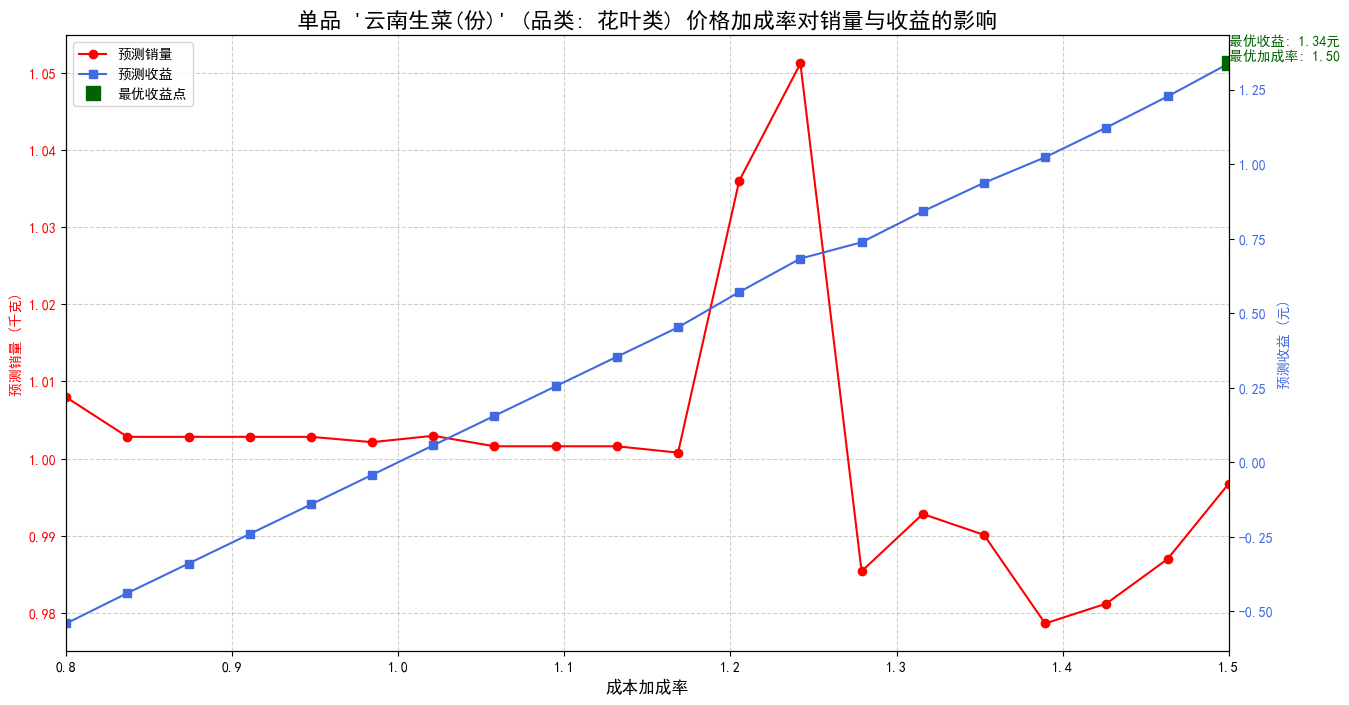

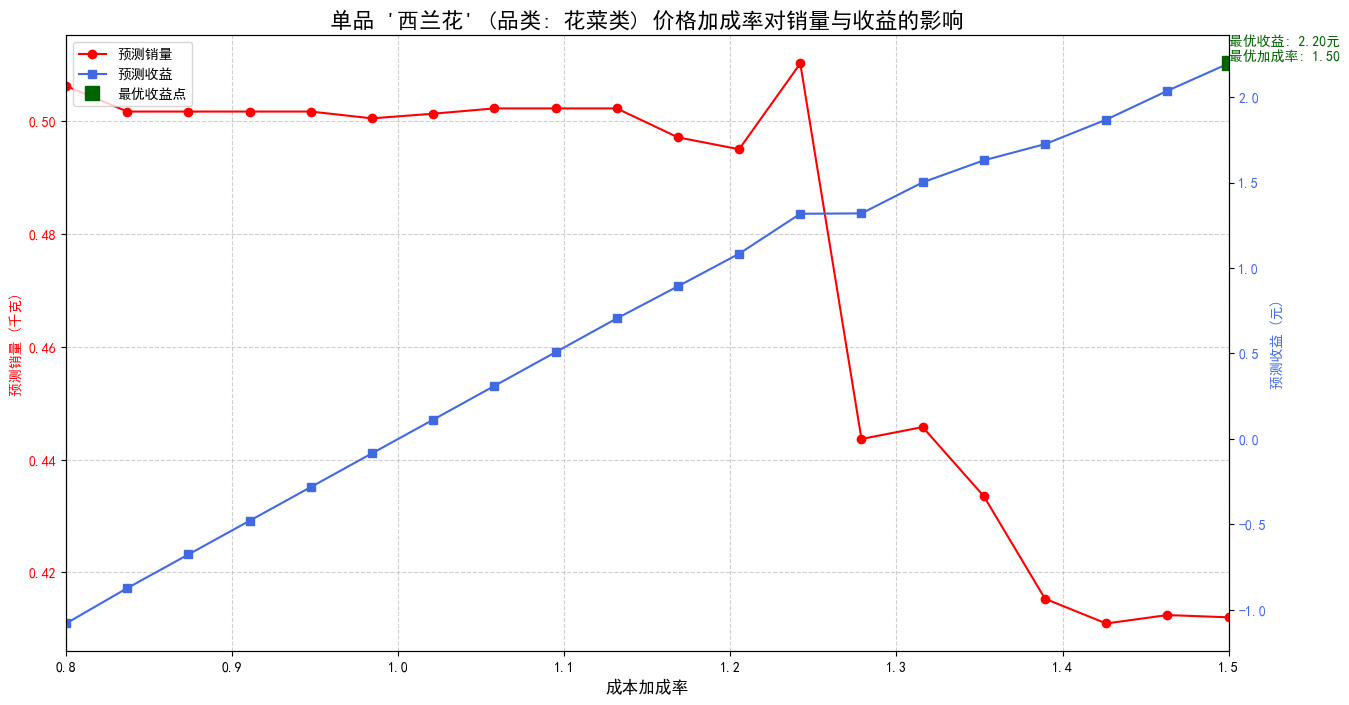

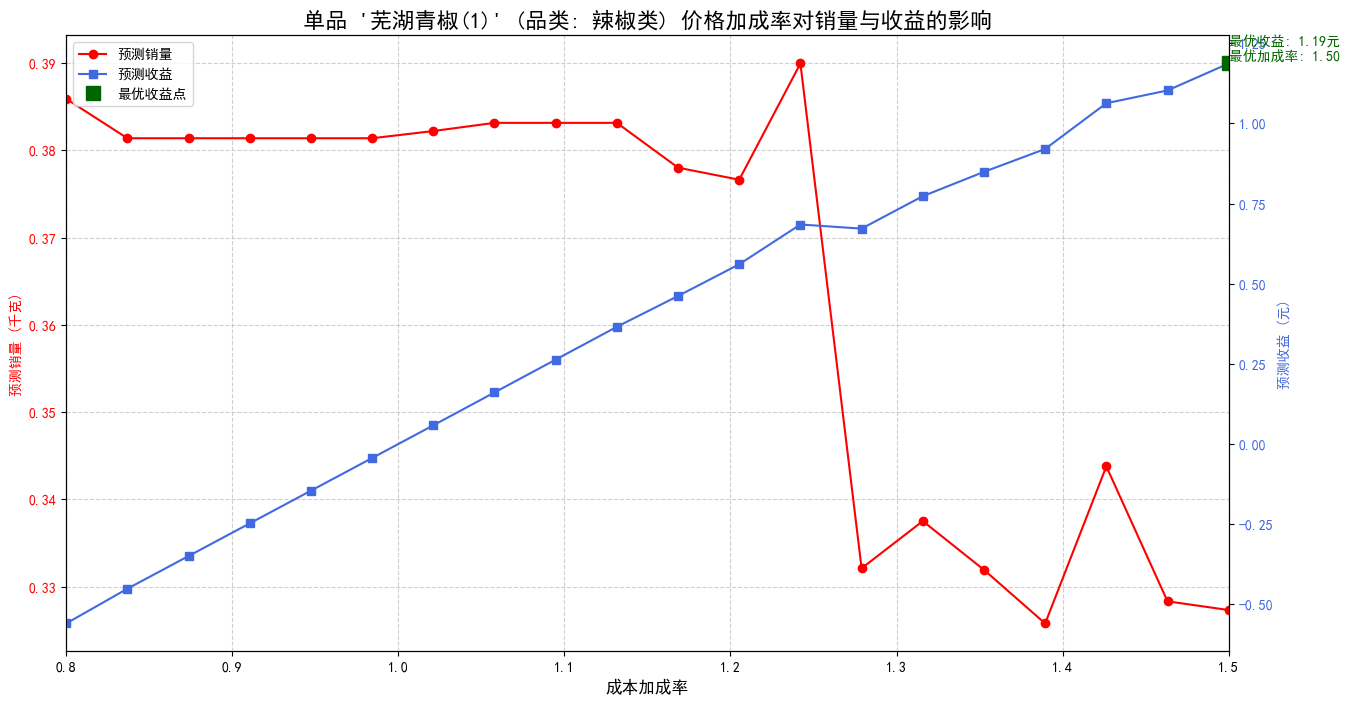

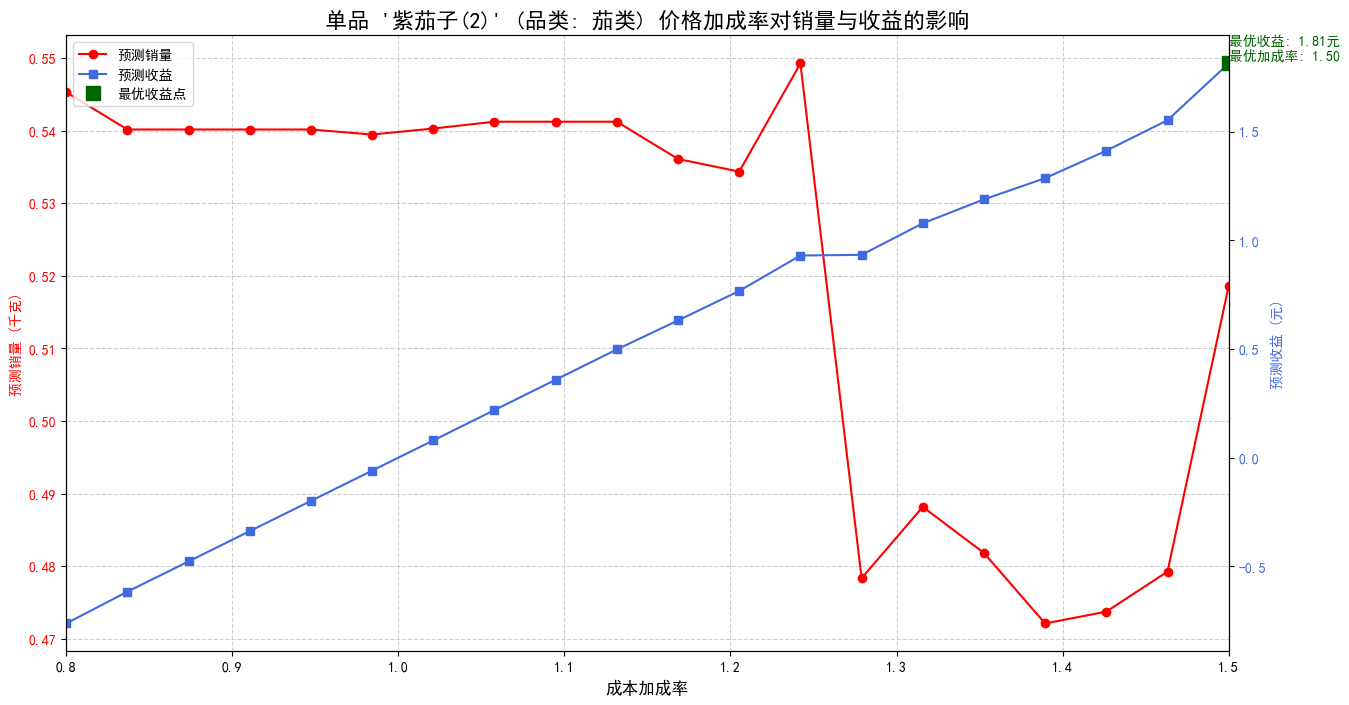

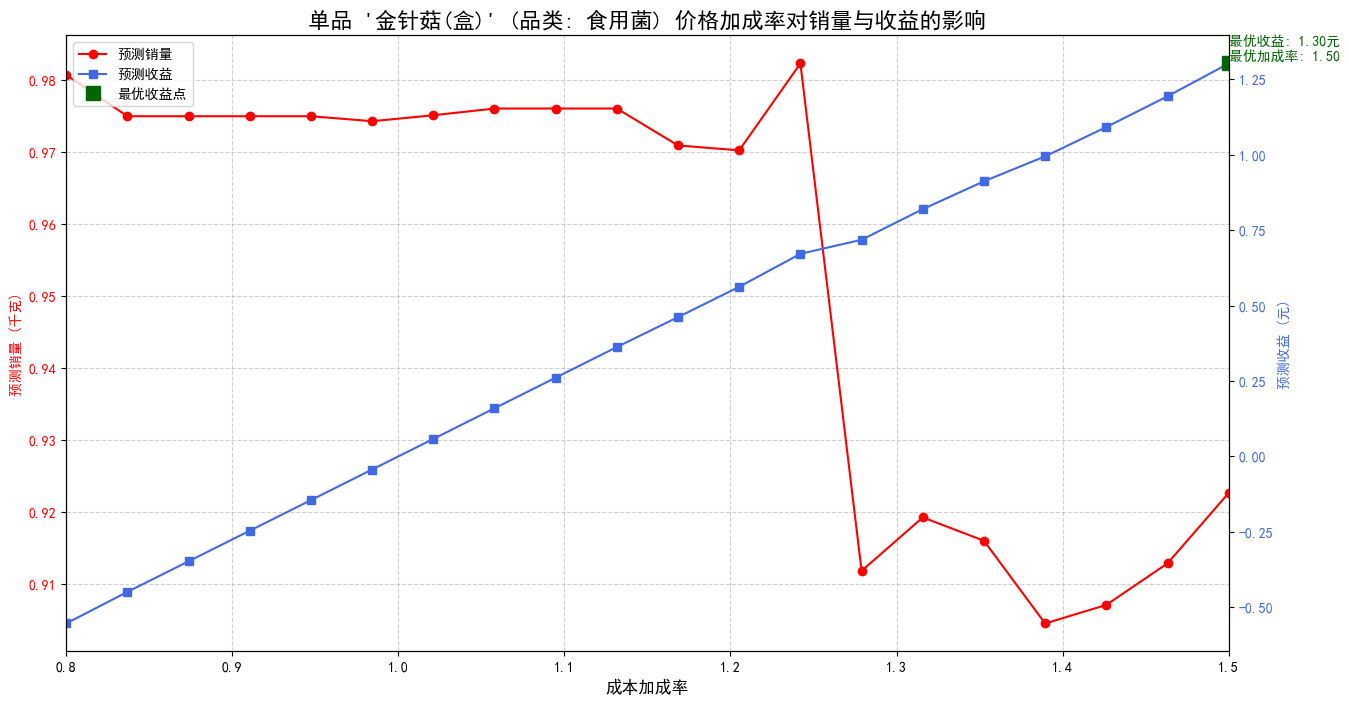

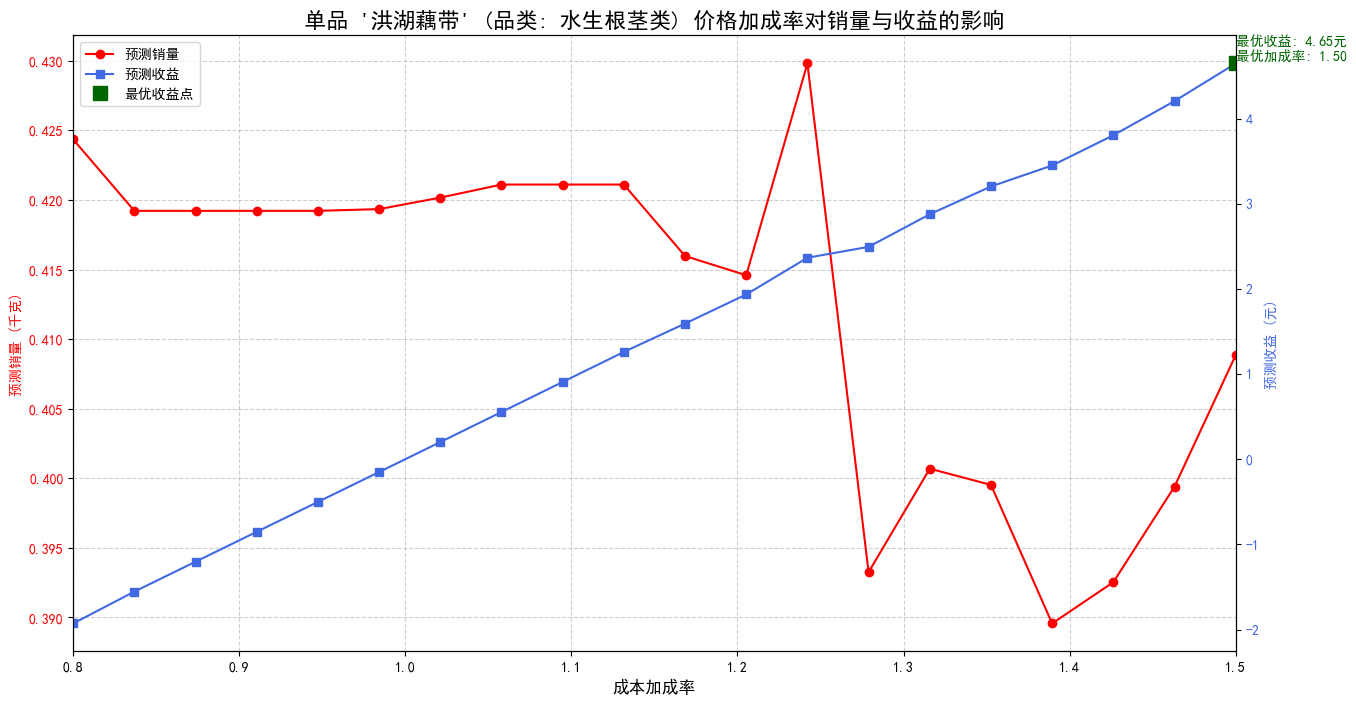


成本加成率影响分析图表已生成完毕。


In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import xgboost as xgb
import sys
import numpy as np
import re
from datetime import datetime, timedelta

# 设置中文字体以正常显示
plt.rcParams['font.family'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

# --- 文件路径设置 ---
sanheyi_file = '三合一.xlsx'
fujian1_file = '附件1.xlsx'
model_file = '单品销量预测模型.xgb'
strategy_file = '最终补货策略清单.xlsx'
prediction_date = pd.to_datetime('2023-07-01')

# --- 辅助函数：智能查找列名 (与您代码一致) ---
def find_column(df_columns, keywords, default_name):
    """根据关键词列表在DataFrame的列名中智能查找最匹配的列名"""
    for col in df_columns:
        if any(re.search(f"{keyword}", col, re.IGNORECASE) for keyword in keywords) and '编码' not in col:
            return col
    for col in df_columns:
        if any(keyword in col for keyword in keywords):
            return col
    return None

# --- 函数：加载和合并数据 (与您代码一致) ---
def load_and_merge_data(sanheyi_file, fujian1_file):
    try:
        df_sanheyi_raw = pd.read_excel(sanheyi_file)
        df_fujian1 = pd.read_excel(fujian1_file)
    except FileNotFoundError as e:
        print(f"错误：确保所有文件存在于当前目录。缺失文件: {e.filename}")
        sys.exit(1)

    df_sanheyi_raw.columns = df_sanheyi_raw.columns.str.strip()
    df_fujian1.columns = df_fujian1.columns.str.strip()
    
    df_sanheyi_raw['单品编码'] = df_sanheyi_raw['单品编码'].astype(str)
    df_fujian1['单品编码'] = df_fujian1['单品编码'].astype(str)
    
    item_name_keywords = ['单品名称', '商品名称', '单品']
    category_name_keywords = ['分类名称', '品类名称', '分类']
    item_name_col_found = find_column(df_fujian1.columns, item_name_keywords, '单品名称')
    category_name_col_found = find_column(df_fujian1.columns, category_name_keywords, '分类名称')
    
    if not item_name_col_found or not category_name_col_found:
        print("严重错误: 未找到合适的列名，请检查 '附件1.xlsx' 文件。")
        sys.exit(1)
        
    df_fujian1_dedup = df_fujian1[[
        '单品编码', item_name_col_found, category_name_col_found
    ]].rename(columns={
        item_name_col_found: '单品名称',
        category_name_col_found: '分类名称'
    }).drop_duplicates(subset=['单品编码'], keep='first')
    
    df_sanheyi_dedup = df_sanheyi_raw.drop_duplicates(subset=['单品编码'], keep='first')
    if '单品名称' in df_sanheyi_dedup.columns:
        df_sanheyi_dedup = df_sanheyi_dedup.drop(columns='单品名称')
    if '分类名称' in df_sanheyi_dedup.columns:
        df_sanheyi_dedup = df_sanheyi_dedup.drop(columns='分类名称')
        
    df_merged_full = pd.merge(df_sanheyi_dedup, df_fujian1_dedup, on='单品编码', how='left')
    
    df_merged_full['销量(千克)'] = df_merged_full['销量(千克)'].fillna(0)
    df_merged_full['销售日期'] = pd.to_datetime(df_merged_full['销售日期'])
    
    df_merged_full['销售成本'] = df_merged_full['批发价格(元/千克)'] * (1 + df_merged_full['损耗率(%)'] / 100)
    df_merged_full['销售成本'] = df_merged_full['销售成本'].replace(0, np.nan)
    df_merged_full.dropna(subset=['销售成本'], inplace=True)
    df_merged_full['销售收益'] = (df_merged_full['销售单价(元/千克)'] - df_merged_full['销售成本']) * df_merged_full['销量(千克)']
    df_merged_full['成本加成率'] = df_merged_full['销售单价(元/千克)'] / df_merged_full['销售成本']
    
    return df_merged_full

# --- 核心逻辑开始 ---
print("--- 正在加载并处理数据，请稍候... ---")
df_data = load_and_merge_data(sanheyi_file, fujian1_file)

print(f"--- 正在加载模型文件: {model_file} ---")
xgb_model = xgb.XGBRegressor()
try:
    xgb_model.load_model(model_file)
    print("已成功加载现有的XGBoost模型！")
except xgb.core.XGBoostError:
    print(f"错误：无法加载模型文件 '{model_file}'。请确保该文件存在于当前目录。")
    sys.exit(1)

model_features = xgb_model.get_booster().feature_names

# --- 读取策略文件并筛选出每个品类的最优单品 ---
try:
    df_strategy = pd.read_excel(strategy_file)
    print(f"已成功加载策略文件: {strategy_file}")
    
    df_strategy['最优收益(元)'] = pd.to_numeric(df_strategy['最优收益(元)'], errors='coerce')
    df_strategy = df_strategy.dropna(subset=['最优收益(元)'])
    
    items_to_analyze = {}
    for category in df_strategy['分类名称'].unique():
        top_item = df_strategy[df_strategy['分类名称'] == category].nlargest(1, '最优收益(元)')
        if not top_item.empty:
            items_to_analyze[category] = top_item['单品名称'].iloc[0]
            
except FileNotFoundError:
    print(f"错误：未找到策略文件 '{strategy_file}'。")
    sys.exit(1)
except Exception as e:
    print(f"处理策略文件时出错: {e}")
    sys.exit(1)

if not items_to_analyze:
    print("警告：无法从策略文件中找到任何可分析的单品。")
    sys.exit(0)

print("\n--- 正在生成成本加成率对销量与收益影响的可视化图表 ---")

def visualize_markup_impact(item_name, category_name):
    """
    针对单个单品，生成成本加成率对销量和收益影响的图表。
    """
    df_item = df_data[df_data['单品名称'] == item_name].copy()
    if df_item.empty:
        print(f"警告: 数据中未找到单品 '{item_name}'，跳过可视化。")
        return

    # 1. 估算单品成本
    avg_wholesale_price = df_item['批发价格(元/千克)'].mean()
    avg_loss_rate = df_item['损耗率(%)'].mean()
    estimated_cost = avg_wholesale_price * (1 + avg_loss_rate / 100)

    if pd.isna(estimated_cost) or estimated_cost == 0:
        print(f"警告: 无法计算单品 '{item_name}' 的销售成本，跳过可视化。")
        return

    # 2. 准备模拟数据
    markup_rates = np.linspace(0.8, 1.5, 20)
    predicted_sales_list = []
    predicted_revenue_list = []

    # 3. 获取其他预测所需特征
    day_of_week = prediction_date.weekday()
    month = prediction_date.month
    prev_week_date = prediction_date - timedelta(weeks=1)
    
    prev_week_sales_df = df_data[(df_data['销售日期'] == prev_week_date) & (df_data['单品名称'] == item_name)]
    prev_week_sales = prev_week_sales_df['销量(千克)'].sum() if not prev_week_sales_df.empty else 0

    # 4. 循环预测不同加成率下的销量和收益
    for markup in markup_rates:
        features_dict = {
            '星期几': [day_of_week],
            '月份': [month],
            '成本加成率': [markup],
            '前一周同期销量(千克)': [prev_week_sales]
        }
        
        X_pred = pd.DataFrame(features_dict).reindex(columns=model_features, fill_value=0)
        item_col = f'单品_{item_name}'
        if item_col in X_pred.columns:
            X_pred[item_col] = 1
        
        predicted_sales = xgb_model.predict(X_pred)[0]
        predicted_sales = max(0, predicted_sales)
        predicted_sales_list.append(predicted_sales)

        sales_price = estimated_cost * markup
        predicted_revenue = (sales_price - estimated_cost) * predicted_sales
        predicted_revenue_list.append(predicted_revenue)

    # 5. 绘制图表
    plt.figure(figsize=(15, 8)) # 创建新的图表窗口
    ax = plt.gca()
    ax2 = ax.twinx()
    
    ax.plot(markup_rates, predicted_sales_list, color='red', marker='o', label='预测销量')
    ax.set_ylabel('预测销量 (千克)', color='red')
    ax.tick_params(axis='y', labelcolor='red')

    ax2.plot(markup_rates, predicted_revenue_list, color='royalblue', marker='s', label='预测收益')
    ax2.set_ylabel('预测收益 (元)', color='royalblue')
    ax2.tick_params(axis='y', labelcolor='royalblue')

    ax.set_title(f"单品 '{item_name}' (品类: {category_name}) 价格加成率对销量与收益的影响", fontsize=16)
    ax.set_xlabel('成本加成率', fontsize=12)
    ax.set_xlim(markup_rates.min(), markup_rates.max())
    
    # 标注最优收益点
    if len(predicted_revenue_list) > 0:
        max_revenue_index = np.argmax(predicted_revenue_list)
        optimal_markup = markup_rates[max_revenue_index]
        optimal_revenue = predicted_revenue_list[max_revenue_index]
        
        ax2.plot(optimal_markup, optimal_revenue, 's', color='darkgreen', markersize=10, label='最优收益点')
        ax2.text(optimal_markup, optimal_revenue, 
                f'最优收益: {optimal_revenue:.2f}元\n最优加成率: {optimal_markup:.2f}', 
                ha='left', va='bottom', fontsize=10, color='darkgreen')

    # 合并图例
    lines, labels = ax.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax.legend(lines + lines2, labels + labels2, loc='upper left')
    
    ax.grid(True, linestyle='--', alpha=0.6)
    plt.show() # 显示当前图表

# 循环生成图表
for category, item_name in items_to_analyze.items():
    visualize_markup_impact(item_name, category)

print("\n成本加成率影响分析图表已生成完毕。")